In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
import re
from collections import Counter

In [2]:
df = pd.read_json('../data/lyrics_cleaned.json')

In [3]:
df.head()

,artist,title,lyrics,character_count,word_count
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...",2371,447
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,2689,551
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...",1576,304
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...",2203,446
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...",1570,318


In [4]:
df.reset_index(drop=True,inplace=True)

In [5]:
df = df.drop(['character_count', 'word_count'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252 entries, 0 to 6251
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  6252 non-null   object
 1   title   6252 non-null   object
 2   lyrics  6252 non-null   object
dtypes: object(3)
memory usage: 146.7+ KB


In [7]:
df.head()

,artist,title,lyrics
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-..."


In [8]:
df.tail()

,artist,title,lyrics
6247,Lost Boyz,Lifestyles Of The Rich And Shameless,>Freaky Tahverses Mr. CheeksIntro:[Freaky Tah]...
6248,DJ Quik,Safe + Sound,"~Static~ ""Quik you're not a gangster we're not..."
6249,Ty Herndon,What Mattered Most,I thought I knew the girl so well If she was ...
6250,Madonna,Bedtime Story,Today Is the last day That I'm using words ...
6251,Livin' Joy,Dreamer,"Love, life and laughter Is all I beleive. My..."


In [9]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()


def remove_bracketed(song):
    text = re.sub("\[.*?\]", '', song)
    text = re.sub("\(.*?\)", '', text)
    text = re.sub("\{.*?\}", '', text)
    
    return text


def spacy_tokenizer(text, use_stopwords=True, custom_stopwords=set()):
    text = remove_bracketed(text)
    mytokens = parser(text)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else "-PRON-" for word in mytokens ]
#     mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    if use_stopwords:
        mytokens = [word for word in mytokens if word not in (stop_words | custom_stopwords) and word not in punctuations ]
    else:
        mytokens = [word for word in mytokens if word not in punctuations ]

    
    return mytokens


def tokenize_column(dataframe, column_name, use_stopwords=True, custom_stopwords=set()):
    df_ = dataframe.reset_index(drop=True)
    token_list = []
    for song in df_[column_name]:
        token_list.append(spacy_tokenizer(song, use_stopwords, custom_stopwords))
    
    return token_list



In [10]:
lyric_stopwords = set(['hey', 'baby', 'babe', 'woo', 'ha', 'like', 'oh', 'ooh', 'woah', 'yeah'])
df['lyrics_tokens'] = tokenize_column(df, 'lyrics', use_stopwords=True, custom_stopwords=lyric_stopwords)

In [11]:
df.head(10)

,artist,title,lyrics,lyrics_tokens
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, -PRON-, fuck, 12, f..."
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, -PRON-, let..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, -PRON-, bad, guy, proud, t..."
5,Justin Bieber Featuring Quavo,Intentions,"Picture perfect, you don't need no filter Gor...","[picture, perfect, need, filter, gorgeous, -PR..."
6,DaBaby Featuring Roddy Ricch,ROCKSTAR,"Woo, woo I pull up like How you pull up, Bab...","[pull, pull, pull, pull, pull, let, -PRON-, br..."
7,Future Featuring Drake,Life Is Good,Workin' on the weekend like usual Way off in ...,"[workin, weekend, usual, way, deep, end, usual..."
8,Billie Eilish,everything i wanted,I had a dream I got everything I wanted Not ...,"[dream, want, -PRON-, think, -PRON-, bein, hon..."
9,Camila Cabello Featuring DaBaby,My Oh My,"Ha, ha, ha, ha They say he likes a good time ...","[good, time, come, alive, midnight, mama, trus..."


In [12]:
idx = np.random.randint(0, 6252)

In [13]:
print(df.iloc[idx, 0], ' - ', df.iloc[idx, 1],'\n\n-----\n\n', df.iloc[idx, 2], '\n\n-----\n\n', df.iloc[idx, 3])

Justin Timberlake  -  TKO 

-----

 In all, enthrilling new, living sound Kill me with the coo, coochie-coochie-coo Ah, she kill me with the coo, coochie-coochie-coo  Ah, she kill me with the coo, coochie-coochie-coo Ah, she kill me with the coo, coochie-coochie-coo Ah, she kill me with the coo, coochie-coochie-coo  Ah, she kill me with the coo, coochie-coochie-coo  Ah, she kill me with the coo, coochie-coochie-coo  Ah, lights out, TKO  Boo    Baby, everyday in training to get the gold  That's why your body's crazy  But you can't run from yourself, that's where it's difficult  Girl I can see in your eyes that there's something inside that made you evil  Where did you go, 'cause it just ain't fair  Over here thinking 'bout the sh-t you say  Don't know why it gets to me    It cuts right on my eye, yeah it hurt, won't lie  Still can't see, think I saw you with another guy  Can't fight, knocked down, then I got over you  Can't fight no more, you knock me out  What am I supposed to do?    I

In [14]:
barbra = df[df['artist'] == 'Duck Sauce']['lyrics'][2191]

In [15]:
barbra

'Barbra Streisand  Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo   Owoowoowoowoowoo  Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoo  Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Wowowo wowowo wowowowoowoo  Woowoowoowoowoowoowoowoowoowoowoo wowowo wowowo 

In [16]:
set((re.sub("woo*", '', barbra.lower())).split())

{'(merci',
 'barbra',
 'cettes',
 'hugo',
 'o',
 'oo',
 'paroles)',
 'pour',
 'streisand',
 'w',
 'à'}

In [17]:
df.head()

,artist,title,lyrics,lyrics_tokens
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, -PRON-, fuck, 12, f..."
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, -PRON-, let..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, -PRON-, bad, guy, proud, t..."


In [18]:
len(df.columns)

4

In [19]:
df['word_count'] = 0
df['unique_word_count'] = 0
for idx, row in enumerate(df['lyrics']):
    df.iloc[idx, len(df.columns)-2] = len(row.split())
    df.iloc[idx, len(df.columns)-1] = len(set(row.split()))

    
df['token_count'] = 0
df['unique_token_count'] = 0
for idx, row in enumerate(df['lyrics_tokens']):
    df.iloc[idx, len(df.columns)-2] = len(row)
    df.iloc[idx, len(df.columns)-1] = len(set(row))

In [20]:
df.head()

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke...",447,166,206,71
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, -PRON-, fuck, 12, f...",551,209,249,124
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,...",304,100,87,31
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, -PRON-, let...",446,164,135,74
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, -PRON-, bad, guy, proud, t...",318,118,134,38


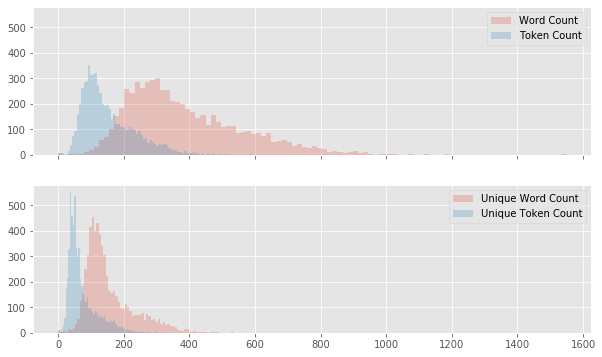

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
ax[0].hist(df['word_count'], bins=100, label='Word Count', alpha=.25)
ax[0].hist(df['token_count'], bins=100, label='Token Count', alpha=.25)
ax[1].hist(df['unique_word_count'], bins=100, label='Unique Word Count', alpha=.25)
ax[1].hist(df['unique_token_count'], bins=100, label='Unique Token Count', alpha=.25)
ax[0].legend(loc='best')
ax[1].legend(loc='best');

''

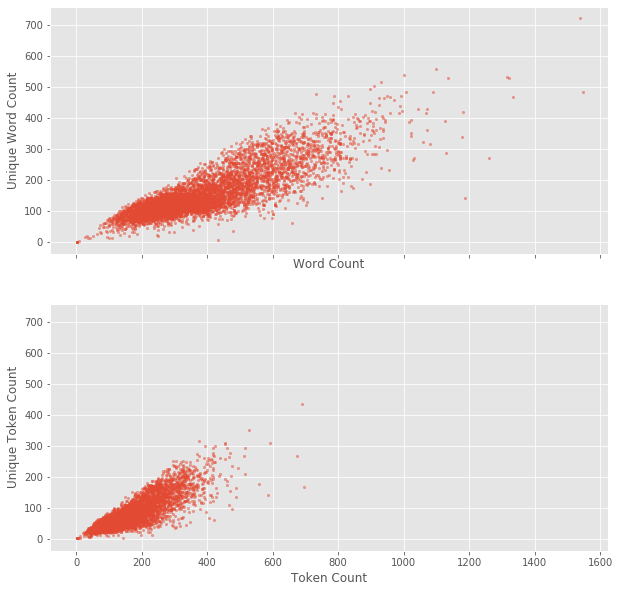

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
ax[0].scatter(df['word_count'], df['unique_word_count'], alpha=0.5, s=6)
ax[1].scatter(df['token_count'], df['unique_token_count'], alpha=0.5, s=6)
ax[0].set_xlabel('Word Count')
ax[1].set_xlabel('Token Count')
ax[0].set_ylabel('Unique Word Count')
ax[1].set_ylabel('Unique Token Count')
;

In [23]:
df[(df['word_count'] > 1100) & (df['unique_word_count'] < 200)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
6147,Nicki French,Total Eclipse Of The Heart,"Turnaround, Every now and then I get a little ...","[turnaround, little, bite, lonely, -PRON-, com...",1186,143,420,60


In [24]:
idx = df[(df['word_count'] > 1100) & (df['unique_word_count'] < 200)].index[0]
wc = df.iloc[idx,:]['word_count']
unique = df.iloc[idx,:]['unique_word_count']
print(unique / wc)

0.1205733558178752


In [25]:
df.iloc[idx,:]['lyrics']

"Turnaround, Every now and then I get a little bit lonely and you're never coming round  Turnaround, Every now and then I get a little bit tired of listening to the sound of my tears  Turnaround, Every now and then I get a little bit nervous that the best of all the years have gone by   Turnaround, Every now and then I get a little bit terrified and then I see the look in your eyes  Turnaround bright eyes, Every now and then I fall apart  Turnaround bright eyes, Every now and then I fall apart    Turnaround, Every now and then I get a little bit restless and I dream of something wild  Turnaround, Every now and then I get a little bit helpless and I'm lying like a child in your arms  Turnaround, Every now and then I get a little bit angry and I know I've got to get out and cry  Turnaround, Every now and then I get a little bit terrified but then I see the look in your eyes  Turnaround bright eyes, Every now and then I fall apart  Turnaround bright eyes, Every now and then I fall apart  

In [26]:
df[(df['word_count'] < 750) & (df['unique_word_count'] > 450)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
6127,Kool G Rap,Fast Life,"(feat. Nas) The time has come, we gotta expan...","[time, come, expand, operation, distribution, ...",732,477,376,316


In [27]:
idx = df[(df['word_count'] < 750) & (df['unique_word_count'] > 450)].index[0]
wc = df.iloc[idx,:]['word_count']
unique = df.iloc[idx,:]['unique_word_count']
print(unique / wc)

0.6516393442622951


In [28]:
df.iloc[idx,:]['lyrics']

'(feat. Nas)  The time has come, we gotta expand, the whole operation   Distribution, New York, to Chicago, L.A.  We gotta set our own market, and enforce it  [Verse One: Kool G Rap]    Champagne wishes of caviar dreams ?a penis didn\'t cream?  With sales of fish scales from triple beams I gleam  Livin the live of rowdy packin fifty cali\'s  Rockin lizard Bally\'s while we do our drug deal in a dark alley  Up in casinos just me and my dino primo  Pushin beam-o\'s then parlay in Reno with two fly latinos  Nas, he runs the whole staff, we count mad for seen bad  We\'ve seen a half a milli dashin out there on the Queens half  Three major players gettin papers by the layers  And those that portray us on the block get rocked like Domateus  Fakers get used to shootin targets, soon as the dark hits  Front on the drug market, bodies get rolled up in a carpet  Those that cheat us try to beat us we got hookers with heaters  that\'ll stray pop and put more shells in your top than Adidas  Da leade

In [29]:
df[df['title'] == 'Rap God']

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...","[look, easy, hurt, feeling, -PRON-, chance, wr...",1539,722,689,435


In [30]:
wc = df[df['title'] == 'Rap God']['word_count'][1520]
unique = df[df['title'] == 'Rap God']['unique_word_count'][1520]
print(unique / wc)

0.4691358024691358


In [31]:
df[(df['token_count'] > 600) & (df['unique_token_count'] >400)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...","[look, easy, hurt, feeling, -PRON-, chance, wr...",1539,722,689,435


In [34]:
def tf(term, document_tokens):
    term_occ = document_tokens.count(term)
    total_tokens = len(document_tokens)
    return term_occ / total_tokens



def get_tf(document_tokens):
    term_freqs = {}
    for token in document_tokens:
        if token not in term_freqs:
            term_freqs[token] = tf(token, document_tokens)
    return term_freqs
    

def get_idf_dict(corpus):
    occ_dict = {}
    for doc in corpus:
        for token in doc:
            if token not in occ_dict:
                occ_dict[token] = 1
            else:
                occ_dict[token] += 1
    return occ_dict

def get_doc_freq_dict(corpus):
    doc_occs = Counter([word for row in corpus for word in set(row)])
    doc_freq = {k: (v / float(len(corpus))) for k, v in doc_occs.items()}
    return doc_freq


def vectorize_tokens(pandas_series):
    docs = pandas_series.to_numpy()
    doc_freq = get_doc_freq_dict(working_df['lyrics_tokens'])
    vocabulary = [k for k,v in doc_freq.items()]
    vectors = np.zeros((len(docs),len(vocabulary)))

    for i in range(len(docs)):
        for j in range(len(vocabulary)):
            term     = vocabulary[j]
            term_tf  = tf(term, docs[i])   # 0.0 if term not found in doc
            term_idf = np.log(1 + (1 / doc_freq[term])) # smooth formula
            vectors[i,j] = term_tf * term_idf
    return vectors, vocabulary



In [103]:
top_artist = df.groupby(by='artist').count().sort_values(by='title',ascending=False).loc[:,'title']
top_artist[:5]

artist
Taylor Swift     58
Kenny Chesney    42
Tim McGraw       39
Keith Urban      37
Drake            33
Name: title, dtype: int64

In [105]:
artist_list = list(top_artist[:5].index)
working_df = df[df['artist'].isin(artist_list)]

song_is_artist = pd.get_dummies(working_df['artist'], prefix='is')

In [106]:
song_is_artist.head()

,is_Drake,is_Keith Urban,is_Kenny Chesney,is_Taylor Swift,is_Tim McGraw
0,1,0,0,0,0
65,0,0,1,0,0
75,0,1,0,0,0
149,0,0,0,1,0
150,0,0,0,1,0


In [107]:
arr, vocab = vectorize_tokens(working_df['lyrics_tokens'])

model_df = pd.DataFrame(arr, columns=vocab)

In [108]:
def run_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=.20)

    rfc = RandomForestClassifier(n_estimators=100,
                                 max_features='auto',
                                 oob_score=True)
    rfc.fit(X_train, y_train)
# STOPPED HERE. TRYING TO FIGURE OUT WHICH FEATURES TO REMOVE
    return rfc.oob_score_, rfc.score(X_test, y_test)


def get_all_scores(df, dummy_targets_df):
    target_oobs = {}
    X = df.to_numpy()
    vocab_to_remove = set()
    for idx, target in enumerate(dummy_targets_df.columns):
        y = dummy_targets_df.iloc[:,idx].to_numpy()
        oob, score = run_model(X, y)
        target_oobs[target] = {'oob': round(oob, 3), 'imbalance': round((sum(y) / len(y)), 3)}
    
    return target_oobs

In [109]:
def get_vocab_to_add(trained_model, col_names, add_perc=0.2):
    num_to_remove = int(len(col_names) * add_perc)
    feat_scores = pd.Series(rfc.feature_importances_,
                               index=col_names)
    top_feats = feat_scores.sort_values()[-num_to_remove:]
    return top_feats

In [110]:
get_all_scores(model_df, song_is_artist)

{'is_Drake': {'oob': 0.904, 'imbalance': 0.158},
 'is_Keith Urban': {'oob': 0.808, 'imbalance': 0.177},
 'is_Kenny Chesney': {'oob': 0.808, 'imbalance': 0.201},
 'is_Taylor Swift': {'oob': 0.737, 'imbalance': 0.278},
 'is_Tim McGraw': {'oob': 0.802, 'imbalance': 0.187}}

In [113]:
is_artist = 'is_Taylor Swift'

arr, vocab_cols = vectorize_tokens(working_df['lyrics_tokens'])
model_df = pd.DataFrame(arr, columns=vocab)

X = arr
y = song_is_artist.iloc[:,song_is_artist.columns.get_loc(is_artist)]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=.20)

In [117]:
rfc = RandomForestClassifier(n_estimators=500,
                             max_features='auto',
                             oob_score=True, 
                             class_weight='balanced_subsample').fit(X_train, y_train)

In [142]:
gbcl = GradientBoostingClassifier(learning_rate=.01, 
                                  n_estimators=100, 
                                  criterion='mae').fit(X_train, y_train)

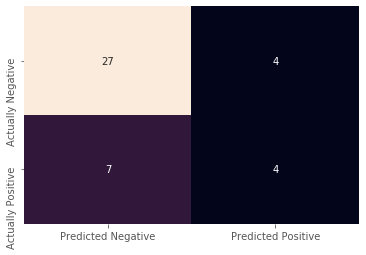

In [143]:
y_true = y_test
y_pred = gbcl.predict(X_test)
conf_mat = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_mat, 
            cbar=False, 
            annot=True,
            fmt='d',
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actually Negative', 'Actually Positive']);

In [129]:
# model = GradientBoostingClassifier()
# learning_rate_param = [.01, .001]
# n_estimators_param = np.arange(100,3100,1000)
# parameters = {'n_estimators' : n_estimators_param,
#              'learning_rate' : learning_rate_param}
# clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# clf.fit(X_train,y_train)
# print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

Accuracy score: 0.738


In [130]:
clf.best_params_

{'learning_rate': 0.001, 'n_estimators': 100}

In [46]:
# feat_scores = pd.Series(rfc.feature_importances_,
#                            index=vocab_cols)
# feat_scores = feat_scores.sort_values()[-50:]

# ax = feat_scores.plot(kind='barh', 
#                       figsize=(10,8),
#                       color='b')
# ax.set_title('Average Gini Importance')
# ax.set_xlabel('Average contribution to information gain');

# get_vocab_to_add(rfc, vocab_cols, add_perc=0.01)